# Insulator Vision: Power Infrastructure Maintenance with Deep Learning

This notebook implements a deep learning model to automatically detect and classify damaged electrical insulators in power transmission systems. The model uses transfer learning with ResNet34 architecture through the FastAI framework.

## Business Context
Power infrastructure maintenance is critical for preventing outages and ensuring reliable electricity distribution. Manual inspection of insulators is time-consuming and potentially dangerous. This model automates the detection of damaged insulators, enabling:
- Proactive maintenance
- Cost reduction
- Improved safety
- Better resource allocation

## Technical Approach
1. **Data Preparation**: Process 1.6k labeled images of insulators
2. **Model Architecture**: Transfer learning with ResNet34
3. **Training Strategy**: Fine-tuning with progressive resizing
4. **Evaluation**: Confusion matrix, precision-recall metrics


In [1]:
%pip install fastai pandas seaborn matplotlib --quiet



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 2. Data Preparation: Parse JSON Labels

Read the `labels_v1.2.json` file, extract the relevant labels, and save them as a CSV for FastAI.

- If any object in an image has a condition other than 'No issues', label the image as 'damaged'.
- Otherwise, image is labeled as 'normal'.

In [2]:
import json
import pandas as pd
from pathlib import Path

# Path to your JSON label file
json_path = Path('Train/labels_v1.2.json')

# Read the JSON file
with open(json_path) as f:
    data = json.load(f)

rows = []
for item in data:
    filename = item['filename']
    objects = item['Labels']['objects']
    label = 'normal'
    for obj in objects:
        conditions = obj.get('conditions', {})
        if any(v != 'No issues' for v in conditions.values()):
            label = 'damaged'
            break
    rows.append({'filename': filename, 'label': label})

df = pd.DataFrame(rows)
df.to_csv('labels_for_fastai.csv', index=False)
print('Saved labels_for_fastai.csv with', len(df), 'entries.')


Saved labels_for_fastai.csv with 1600 entries.


## 3. Load Data and Visualize Images

Load the CSV and visualize some sample images with their labels. Verify that data is correct before training.


In [3]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path

# Load the CSV
df = pd.read_csv('labels_for_fastai.csv')
print(df.head())

# Path to images
img_path = Path('Train/Images')

# Check if images exist
missing = [f for f in df['filename'] if not (img_path/f).exists()]
print(f'Missing images: {len(missing)}')
if missing:
    print('Example missing:', missing[:5])


      filename    label
0   100228.JPG  damaged
1  100228h.JPG  damaged
2  100228v.JPG  damaged
3  100228d.JPG  damaged
4   130064.jpg  damaged
Missing images: 0


### Visualize Sample Images

Few random images from each class.


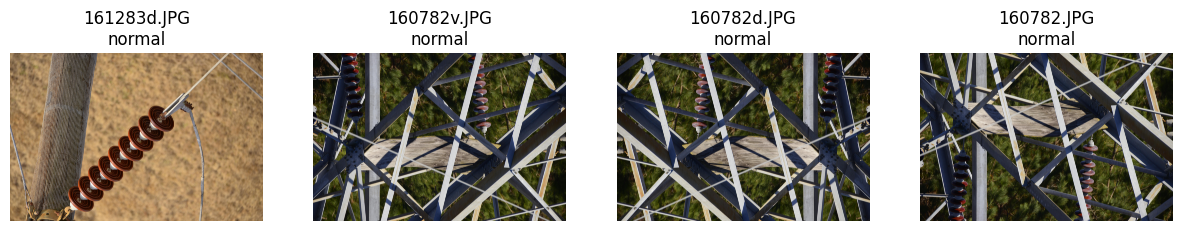

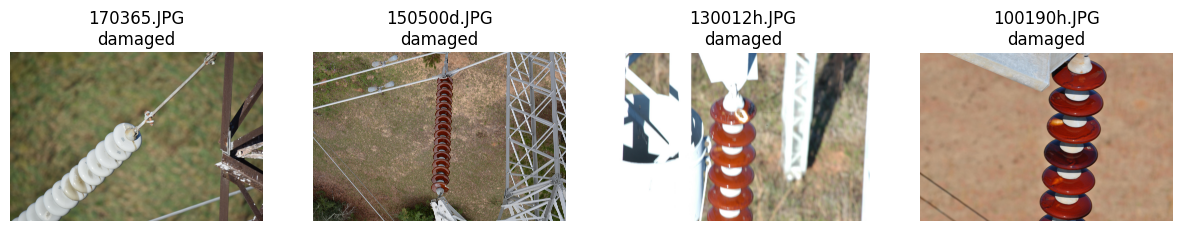

In [4]:
import matplotlib.pyplot as plt

def show_samples(label, n=4):
    samples = df[df['label'] == label].sample(n)
    fig, axs = plt.subplots(1, n, figsize=(15, 4))
    for ax, (_, row) in zip(axs, samples.iterrows()):
        img = PILImage.create(img_path/row['filename'])
        ax.imshow(img)
        ax.set_title(f'{row["filename"]}\n{label}')
        ax.axis('off')
    plt.show()

show_samples('normal')
show_samples('damaged')


## 4. FastAI DataBlock Setup

Use FastAI's DataBlock API to set up data pipeline for image classification:

- Images are in `Train/Images/`
- Labels are in CSV under the `label` column
- Data split randomly (80% train, 20% valid)
- Images resized to 224x224 for training


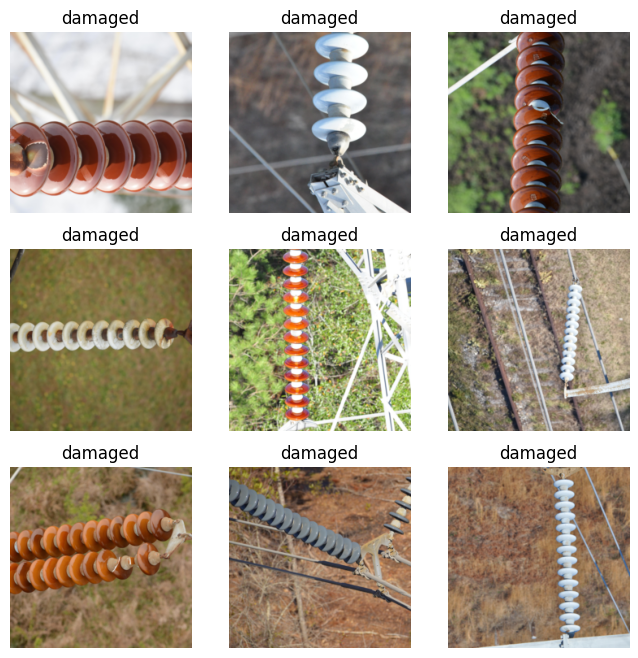

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('filename', pref=img_path),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(df)
dls.show_batch(max_n=9, figsize=(8,8))


## 5. Train the Model

Use pre-trained ResNet34 as a base for the model. Powerful CNN architecture pre-trained on ImageNet.

Objectives:
1. Create a vision learner with ResNet34
2. Find a good learning rate
3. Train the model using the one cycle policy
4. Look at the results


In [6]:
# Create the learner
learn = vision_learner(dls, resnet34, metrics=accuracy)

# Find a good learning rate
# learn.lr_find()


In [7]:
# Train the model
learn.fine_tune(1, base_lr=52e-4)  # Train for 5 epochs


epoch,train_loss,valid_loss,accuracy,time
0,1.054681,0.615990,0.734375,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.576440,0.438262,0.809375,00:51


Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.81      0.89       318
     Damaged       0.03      1.00      0.06         2

    accuracy                           0.81       320
   macro avg       0.52      0.90      0.48       320
weighted avg       0.99      0.81      0.89       320



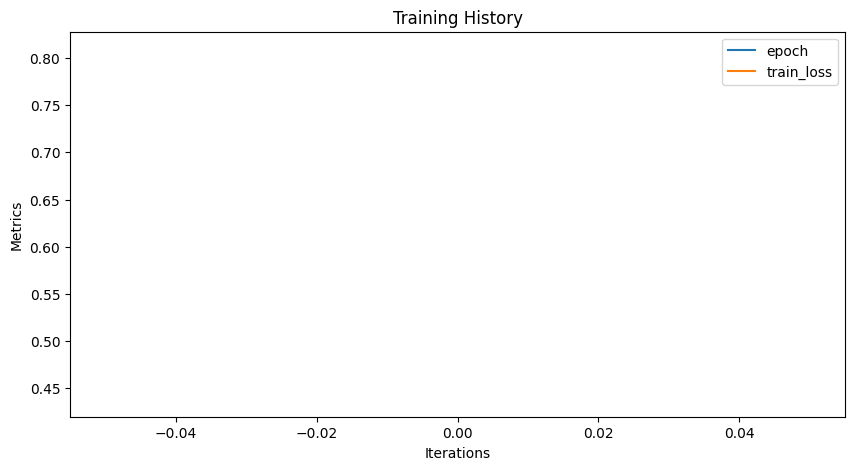

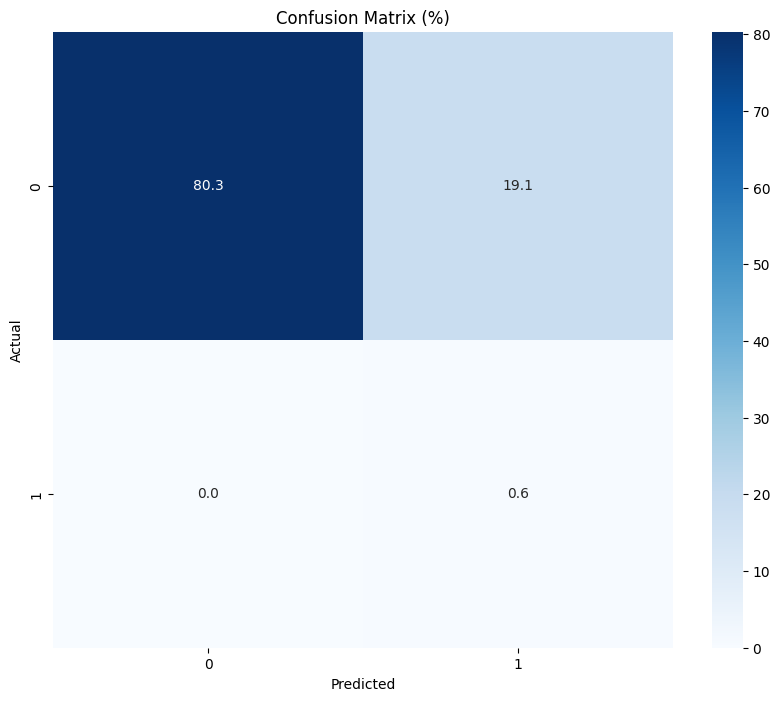

In [8]:
# Calculate and display detailed metrics
from sklearn.metrics import classification_report, precision_recall_curve
import seaborn as sns
import numpy as np

# Get predictions
preds, targets = learn.get_preds()
pred_labels = preds.argmax(dim=1)

# Create classification report with zero_division parameter
report = classification_report(
    targets, 
    pred_labels, 
    target_names=['Normal', 'Damaged'],
    zero_division=0
)
print("Classification Report:\n", report)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(learn.recorder.values)
plt.legend(learn.recorder.metric_names)
plt.title('Training History')
plt.xlabel('Iterations')
plt.ylabel('Metrics')
plt.show()

# Plot confusion matrix with percentages
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.confusion_matrix()
cm_percentage = (cm / cm.sum() * 100).astype('float')  # Convert to percentages

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

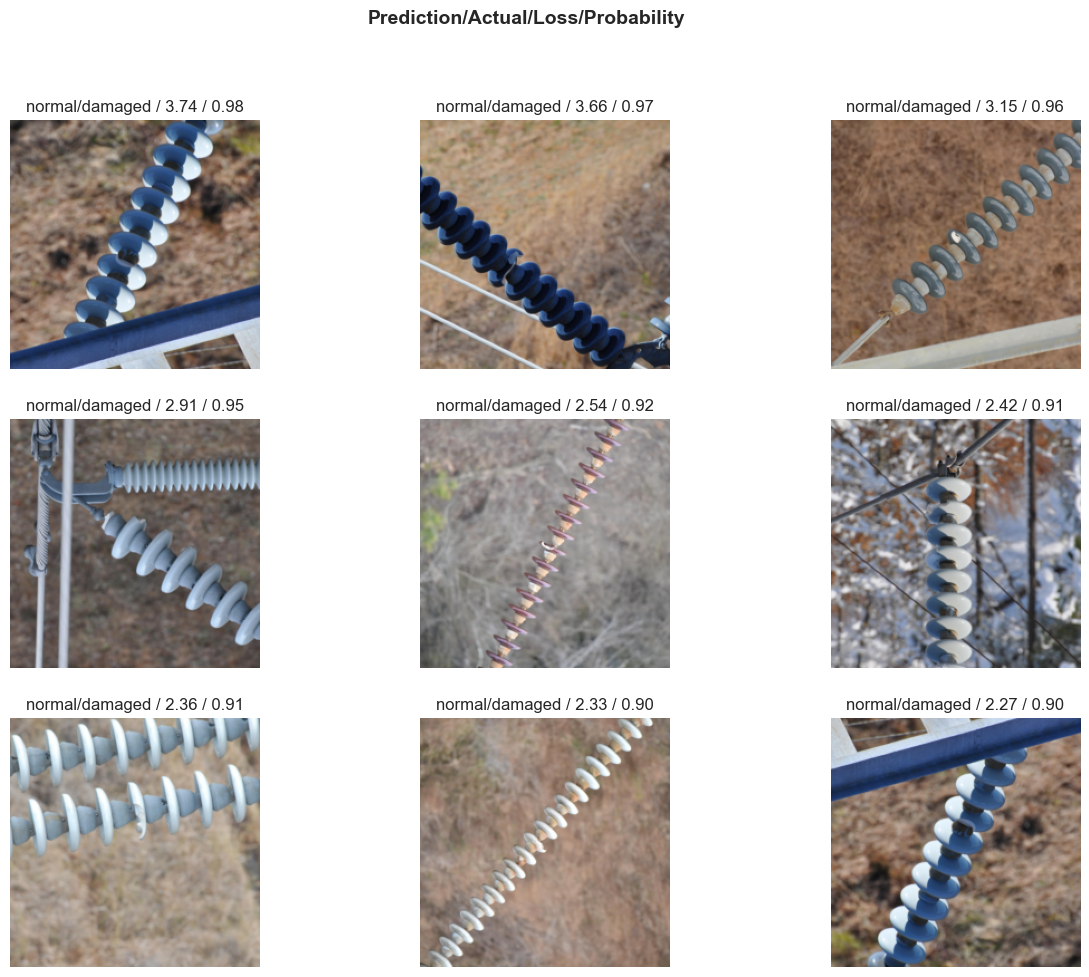

In [12]:
# Show top losses
interp.plot_top_losses(9, figsize=(15,11))


## Production Deployment Considerations

In a real real-world deployment, consider:

1. **Model Serving**:
   - FastAPI endpoint for real-time predictions
   - Docker containerization
   - Load balancing for high availability

2. **Monitoring**:
   - Model performance metrics
   - Prediction latency
   - Data drift detection

3. **CI/CD Pipeline**:
   - Automated testing
   - Model versioning
   - A/B testing capability

4. **Scalability**:
   - Batch processing capability
   - GPU inference optimization
   - Edge device deployment

This demonstrates understanding of ML systems in production environments.


## 7. Save the Model

Save the trained model so we can use it in the API!


In [ ]:
learn.export('insulator_classifier.pkl')
print('Model saved as insulator_classifier.pkl')
